# Multi Summaries Demo

The Multi-Summaries package offers a tool for computing (k-forward bisimulation based) graph summaries and combining them into one large multi-summary graph. In this tutorial you will run the pipeline on (ntriples) graphs and analyze the outcomes. Please run the following cell to import dependencies.

In [11]:
from summary_loader.summary_interface import SummaryInterface
import subprocess
from pathlib import Path
from pprint import pp
from IPython.display import SVG, display

The following cell will set up the requirements for this library. The first time you run it, it will install Boost for C++. This can take over 10 minutes, so please be pantient when running the following cell.

In [2]:
setup_script_file = "setup_experiments.sh"
setup_script_path = Path("./multi-summaries/setup/setup_experiments.sh")

# This will set up Boost when running for the first time and will take a few minutes to run
print("Setting up. If this is the first run, this will take a few minutes.")
subprocess.run(
    ["/bin/bash", setup_script_file, "-y"],
    cwd="./multi-summaries/setup/",
    capture_output=True,
    text=True
)
print("Setting up successfull.")

Setting up. If this is the first run, this will take a few minutes.
Setting up successfull.


Run the following cell to set up the Python interface.

In [8]:
git_hash = subprocess.run(
    ["git", "rev-parse", "HEAD"],
    cwd="./multi-summaries/",
    capture_output=True,
    text=True
).stdout.strip()

path_to_experiment_directory = f"./multi-summaries/{git_hash}/"
summarizer_interface = SummaryInterface(path_to_experiment_directory)
print(f"The following directory should contain store the results of the upcomming experiments: {path_to_experiment_directory}")

The following directory should contain store the results of the upcomming experiments: ./multi-summaries/74a487290727dcc6bd2c16fa289583fa54df06b5/


You can run the cell below to print the setting for the experiment. Most of the settings are meant for setting up slurm job scripts. For this demo you do not have to change any of the settings. If you are interested the README in the `multi-summaries/` directory gives some more details on the settings. Do note the different components:
1. `run_all` is meant to rnn the full pipeline of components.
2. `preprocessor` takes in an ntriples (`.nt`) file and after preprocessing returns a compact binary file, encoding the pre-processed graph.
3. `bisimulator` reads the output from the preprocessor and computes several more-and-more refined partitions over the vertex set of the graph.
4. `summary_graphs_creator` takes the partitions generated by the bisimulator and combines them in one big joint (quotient-like) graph.
5. `results_plotter` plots some statistics about the generated multi-summary.
6. `serializer` will take the output of the summary graph creator and serializes it into several ntriples files.

In [9]:
experiment_settings = summarizer_interface.experiment_settings
pp(experiment_settings)

{'run_all': {'plot_statistics': 'true', 'serialize_to_ntriples': 'true'},
 'preprocessor': {'job_name': 'preprocessing',
                  'time': '48:00:00',
                  'N': '1',
                  'ntasks_per_node': '1',
                  'partition': 'defq',
                  'output': 'slurm_preprocessor.out',
                  'nodelist': '',
                  'skipRDFlists': 'false',
                  'skip_literals': 'false',
                  'laundromat': 'false',
                  'types_to_predicates': 'false',
                  'use_lz4': 'false',
                  'lz4_command': '/usr/local/lz4'},
 'bisimulator': {'job_name': 'bisimulating',
                 'time': '48:00:00',
                 'N': '1',
                 'ntasks_per_node': '1',
                 'partition': 'defq',
                 'output': 'slurm_bisimulator.out',
                 'nodelist': '',
                 'bisimulation_mode': 'run_k_bisimulation_store_partition_condensed_timed',
           

The following code sets the dataset that we will run the multi-summarizer on. You can change the path to any ntriples file. We have provided some already in `./data/`.

In [25]:
dataset_path = "./data/fb15k.nt"
summarizer_interface.set_dataset(dataset_path)

The following cell will run the full pipeline and merge the files created by the serialized into one big ntriples file. It wi ll likely complain about the `sbatch` command not being found. This is expected and the code should happily continue without it.

In [26]:
summarizer_interface.run_experiment()
summarizer_interface.merge_files("cdirs")


##### SETTING UP PREPROCESSOR EXPERIMENT #####
Using the following settings:
job_name=preprocessing
time=48:00:00
N=1
ntasks_per_node=1
partition=defq
output=slurm_preprocessor.out
nodelist=
skipRDFlists=false
skip_literals=false
laundromat=false
types_to_predicates=false
use_lz4=false
lz4_command=/usr/local/lz4
Creating slurm script
Ignored error on line 225: sbatch_command=$(command -v sbatch)
This command is expected to fail if  is not available
sbatch command not found
Running slurm script directly


./preprocessor.sh: line 15: sbatch: command not found
	Command being timed: "../code/bin/preprocessor /app/multi-summaries_demo/data/simple_chain.nt ./"
	User time (seconds): 0.12
	System time (seconds): 1.19
	Percent of CPU this job got: 98%
	Elapsed (wall clock) time (h:mm:ss or m:ss): 0:01.33
	Average shared text size (kbytes): 0
	Average unshared data size (kbytes): 0
	Average stack size (kbytes): 0
	Average total size (kbytes): 0
	Maximum resident set size (kbytes): 266112
	Average resident set size (kbytes): 0
	Major (requiring I/O) page faults: 12
	Minor (reclaiming a frame) page faults: 65728
	Voluntary context switches: 10
	Involuntary context switches: 1
	Swaps: 0
	File system inputs: 1656
	File system outputs: 32
	Socket messages sent: 0
	Socket messages received: 0
	Signals delivered: 0
	Page size (bytes): 4096
	Exit status: 0
./bisimulator.sh: line 15: sbatch: command not found
	Command being timed: "../code/bin/bisimulator run_k_bisimulation_store_partition_condensed_time


##### SETTING UP BISIMULATOR EXPERIMENT #####
Using the following settings:
job_name=bisimulating
time=48:00:00
N=1
ntasks_per_node=1
partition=defq
output=slurm_bisimulator.out
nodelist=
bisimulation_mode=run_k_bisimulation_store_partition_condensed_timed
typed_start=true
Creating slurm script
Ignored error on line 153: sbatch_command=$(command -v sbatch)
This command is expected to fail if  is not available
sbatch command not found
Running slurm script directly

##### SETTING UP SUMMARY GRAPH CREATOR EXPERIMENT #####
Using the following settings:
job_name=summary_graphs_creation
time=48:00:00
N=1
ntasks_per_node=1
partition=defq
output=slurm_summary_graphs_creator.out
nodelist=
Creating slurm script
Ignored error on line 142: sbatch_command=$(command -v sbatch)
This command is expected to fail if  is not available
sbatch command not found
Running slurm script directly


	Command being timed: "../code/bin/create_condensed_summary_graph_from_partitions ./"
	User time (seconds): 0.00
	System time (seconds): 0.00
	Percent of CPU this job got: 68%
	Elapsed (wall clock) time (h:mm:ss or m:ss): 0:00.01
	Average shared text size (kbytes): 0
	Average unshared data size (kbytes): 0
	Average stack size (kbytes): 0
	Average total size (kbytes): 0
	Maximum resident set size (kbytes): 4480
	Average resident set size (kbytes): 0
	Major (requiring I/O) page faults: 10
	Minor (reclaiming a frame) page faults: 239
	Voluntary context switches: 8
	Involuntary context switches: 0
	Swaps: 0
	File system inputs: 1544
	File system outputs: 168
	Socket messages sent: 0
	Socket messages received: 0
	Signals delivered: 0
	Page size (bytes): 4096
	Exit status: 0
./results_plotter.sh: line 15: sbatch: command not found



##### SETTING UP RESULT PLOTTER EXPERIMENT #####
Using the following settings:
job_name=plotting_results
time=48:00:00
N=1
ntasks_per_node=1
partition=defq
output=slurm_results_plotter.out
nodelist=
Creating slurm script
Ignored error on line 149: sbatch_command=$(command -v sbatch)
This command is expected to fail if  is not available
sbatch command not found
Running slurm script directly


Calculating average of kernels: 100%|██████████| 22/22 [00:00<00:00, 214.74it/s]
	Command being timed: "python /app/multi-summaries_demo/multi-summaries/74a487290727dcc6bd2c16fa289583fa54df06b5/simple_chain/../code/python/summary_loader/graph_stats.py ./ -v"
	User time (seconds): 16.62
	System time (seconds): 9.09
	Percent of CPU this job got: 142%
	Elapsed (wall clock) time (h:mm:ss or m:ss): 0:18.00
	Average shared text size (kbytes): 0
	Average unshared data size (kbytes): 0
	Average stack size (kbytes): 0
	Average total size (kbytes): 0
	Maximum resident set size (kbytes): 451040
	Average resident set size (kbytes): 0
	Major (requiring I/O) page faults: 95
	Minor (reclaiming a frame) page faults: 226552
	Voluntary context switches: 1108
	Involuntary context switches: 907
	Swaps: 0
	File system inputs: 35592
	File system outputs: 1824
	Socket messages sent: 0
	Socket messages received: 0
	Signals delivered: 0
	Page size (bytes): 4096
	Exit status: 0
./serializer.sh: line 15: sbatch:


##### SETTING UP SERIALIZER EXPERIMENT #####
Using the following settings:
job_name=serializing_to_ntriples
time=48:00:00
N=1
ntasks_per_node=1
partition=defq
output=slurm_serializer.out
nodelist=
Creating slurm script
Ignored error on line 149: sbatch_command=$(command -v sbatch)
This command is expected to fail if  is not available
sbatch command not found
Running slurm script directly


	Command being timed: "python /app/multi-summaries_demo/multi-summaries/74a487290727dcc6bd2c16fa289583fa54df06b5/simple_chain/../code/python/summary_loader/serialize_to_ntriples.py ./ hash"
	User time (seconds): 0.06
	System time (seconds): 0.03
	Percent of CPU this job got: 93%
	Elapsed (wall clock) time (h:mm:ss or m:ss): 0:00.10
	Average shared text size (kbytes): 0
	Average unshared data size (kbytes): 0
	Average stack size (kbytes): 0
	Average total size (kbytes): 0
	Maximum resident set size (kbytes): 14464
	Average resident set size (kbytes): 0
	Major (requiring I/O) page faults: 0
	Minor (reclaiming a frame) page faults: 1687
	Voluntary context switches: 7
	Involuntary context switches: 4
	Swaps: 0
	File system inputs: 584
	File system outputs: 64
	Socket messages sent: 0
	Socket messages received: 0
	Signals delivered: 0
	Page size (bytes): 4096
	Exit status: 0


So now that we have run the pipeline, what has acutally happenend. The bisimulator has created several partitions on the nodes of the input graph, each more refined than the one before it. Each partition represents a way of clustering nodes together (using forward bisumilation). Each of these partitions could represent its own quotient graph (a particular compacted representation of the original graph). Instead of creating a set of indepentend quotient graphs, however, we use some to combine them into one larger graph.

If that sounds like a lot to take in, then just know that we have now created a new graph in which each node represents a set of nodes in the original graph (and these sets might overlap). This representation has several nice properties, including the potential to compress the original graph if it has enough repeated structures.

The following cell displays how big the parts are in each partition. The horizontal axis corresponds to the number of partitions created. The vertical axis represents the size of parts in the repsective partition. Finally, the color represents how many blocks there are of a given size. Due to rounding, this plot may not be very accurate on smaller datasets. The provided `fb15k.nt` dataset, however, should generate a useful plot. Can you see how this plot indeed shows that the partitions become more refined (i.e. more, smaller parts)?

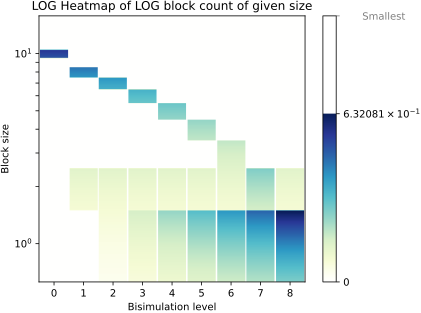

In [27]:
dataset_name = Path(dataset_path).stem
dataset_plots_path = path_to_experiment_directory + f"{dataset_name}/results/"

stats_plot = "per_level_statistics.svg"

display(SVG(filename=dataset_plots_path+block_sizes_plot))

If the input graph is **not too big**, you can run the cells below to compare the original graph to its multi-summary. Note that for small graphs the multi-summary is often bigger than the original.

This cell will print out the raw data of the original graph:

In [28]:
with open(dataset_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i == 999:
            print("Stopped printing after 1000 triples")
            break

<v1> <e1> <v2> .
<v2> <e1> <v3> .
<v3> <e1> <v4> .
<v4> <e1> <v5> .
<v5> <e1> <v6> .
<v6> <e1> <v7> .
<v7> <e1> <v8> .
<v8> <e1> "literally a value" .


This cell will print out the raw data of the respective multi-summary graph:

In [29]:
multi_summary_path = path_to_experiment_directory + f"{dataset_name}/rdf_summary_graph/output_graph.nt"
with open(multi_summary_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        print(line.strip())
        if i == 999:
            print("Stopped printing after 1000 triples")
            break

<http://cs.vu.nl/clustering#hash_block-SjkYzdZe/W3Xq0DPdmf+8iyoM8fGO/WknYjRNAamaoM=> <http://cs.vu.nl/clustering#contains> _:literalNode .
<http://cs.vu.nl/clustering#hash_block-SjkYzdZe/W3Xq0DPdmf+8iyoM8fGO/WknYjRNAamaoM=> <http://cs.vu.nl/clustering#contains> _:rdfTypeNode .
<http://cs.vu.nl/clustering#hash_block-SjkYzdZe/W3Xq0DPdmf+8iyoM8fGO/WknYjRNAamaoM=> <http://cs.vu.nl/clustering#contains> <v1> .
<http://cs.vu.nl/clustering#hash_block-SjkYzdZe/W3Xq0DPdmf+8iyoM8fGO/WknYjRNAamaoM=> <http://cs.vu.nl/clustering#contains> <v2> .
<http://cs.vu.nl/clustering#hash_block-SjkYzdZe/W3Xq0DPdmf+8iyoM8fGO/WknYjRNAamaoM=> <http://cs.vu.nl/clustering#contains> <v3> .
<http://cs.vu.nl/clustering#hash_block-SjkYzdZe/W3Xq0DPdmf+8iyoM8fGO/WknYjRNAamaoM=> <http://cs.vu.nl/clustering#contains> <v4> .
<http://cs.vu.nl/clustering#hash_block-SjkYzdZe/W3Xq0DPdmf+8iyoM8fGO/WknYjRNAamaoM=> <http://cs.vu.nl/clustering#contains> <v5> .
<http://cs.vu.nl/clustering#hash_block-SjkYzdZe/W3Xq0DPdmf+8iyoM8fGO/Wkn

Please go to the cell where you loaded in the dataset and try at least two other data sets (remember that we provided some in `./data/`). Once you have done so: Congratulations! Consider this notebook complete.